In [1]:
import numpy as np
from gpu_xray_scattering import XS
from gpu_xray_scattering.Molecule import Molecule
import glob
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_types
from scipy.ndimage import binary_erosion, binary_dilation
import numpy.polynomial.polynomial as poly

def readPDB(fname, sel='protein', psf=None):
    assert sel is not None, "Must provide sel"
    if psf is not None:
        U = mda.Universe(psf, fname)
    else:
        U = mda.Universe(fname)
    if isinstance(sel, str):
        sel = [sel]
    ret = []
    for s in sel:
        Usel = U.select_atoms(s)
        try:
            Uele = Usel.elements
        except:
            guessed_elements = guess_types(U.atoms.names)
            U.add_TopologyAttr('elements', guessed_elements)
        
        ret.append(Usel.positions)
        ret.append(Usel.elements)
    return ret

In [2]:
def readDCD(fname, sel='protein', psf=None):
    assert sel is not None, "Must provide sel"
    assert psf is not None, "Must provide psf"
    U = mda.Universe(psf, fname)
    if isinstance(sel, str):
        sel = [sel]
    ret = []
    for s in sel:
        Usel = U.select_atoms(s)
        try:
            Uele = Usel.elements
        except:
            guessed_elements = guess_types(U.atoms.names)
            U.add_TopologyAttr('elements', guessed_elements)
        P = []
        for ts in U.trajectory:
            P.append(Usel.positions)
        ret.append(np.array(P))
        ret.append(Usel.elements)
    return ret

In [3]:
wb_holo_coord, wb_holo_ele, \
wb_holo_coord_10, wb_holo_ele_10, \
vac_pro_coord, vac_pro_ele, \
vac_lig_coord, vac_lig_ele, \
vac_com_coord, vac_com_ele, \
holo_wat_coord, holo_wat_ele, \
holo_wat_coord_10, holo_wat_ele_10 = \
    readDCD('data/1FIN_sim/holo/output_holo.dcd', psf='data/1FIN_sim/holo/1FIN_holo_wb.psf',
            sel=['all', 
                 'protein or resname IZD or ((resname TIP3 or resname HOH) and around 10 protein)',
                 'protein',
                 'resname IZD',
                 'protein or resname IZD',
                 'resname TIP3 or resname HOH',
                 '(resname TIP3 or resname HOH) and around 10 protein'
                 ])

In [4]:
wb_apo_coord, wb_apo_ele, \
wb_apo_coord_10, wb_apo_ele_10, \
apo_wat_coord, apo_wat_ele, \
apo_wat_coord_10, apo_wat_ele_10 = \
    readDCD('data/1FIN_sim/apo/output_apo.dcd', psf='data/1FIN_sim/apo/1FIN_apo_wb.psf', 
            sel=['all', 
                 'protein or ((resname TIP3 or resname HOH) and around 10 protein)',
                 'resname TIP3 or resname HOH',
                 '(resname TIP3 or resname HOH) and around 10 protein'
                 ])

In [5]:
scatter = XS.Scatter(q=np.linspace(0.03, 1.2, num=800), use_oa=1)

In [6]:
wb_holo_mol = Molecule(coordinates=wb_holo_coord, elements=wb_holo_ele)
wb_holo_mol_10 = Molecule(coordinates=wb_holo_coord_10, elements=wb_holo_ele_10)
wb_apo_mol = Molecule(coordinates=wb_apo_coord, elements=wb_apo_ele)
wb_apo_mol_10 = Molecule(coordinates=wb_apo_coord_10, elements=wb_apo_ele_10)
vac_com_mol = Molecule(coordinates=vac_com_coord, elements=vac_com_ele)
vac_pro_mol = Molecule(coordinates=vac_pro_coord, elements=vac_pro_ele)
vac_lig_mol = Molecule(coordinates=vac_lig_coord, elements=vac_lig_ele)
holo_wat_mol = Molecule(coordinates=holo_wat_coord, elements=holo_wat_ele)
holo_wat_mol_10 = Molecule(coordinates=holo_wat_coord_10, elements=holo_wat_ele_10)
apo_wat_mol = Molecule(coordinates=apo_wat_coord, elements=apo_wat_ele)
apo_wat_mol_10 = Molecule(coordinates=apo_wat_coord_10, elements=apo_wat_ele_10)


In [7]:
wb_holo_coord.shape

(21, 93990, 3)

In [8]:
# I(complex, vacuum)
Icv = Ipv = Ilv = Iplvc = dIv = Ips = Ips10 = Ics = Ics10 = dIs = dIs10 = []
Iwp = Ipwpc = Iwp10 = Ipwpc10 = Iwc = Icwcc = Iwc10 = Icwcc10 = []
Ipwcc = Ipwcc10 = Ilwcc = Ilwcc10 = []

for i in range(1, 21):
    print(i)
    wb_holo_mol = Molecule(coordinates=wb_holo_coord[i], elements=wb_holo_ele)
    wb_holo_mol_10 = Molecule(coordinates=wb_holo_coord_10[i], elements=wb_holo_ele_10)
    wb_apo_mol = Molecule(coordinates=wb_apo_coord[i], elements=wb_apo_ele)
    wb_apo_mol_10 = Molecule(coordinates=wb_apo_coord_10[i], elements=wb_apo_ele_10)
    vac_com_mol = Molecule(coordinates=vac_com_coord[i], elements=vac_com_ele)
    vac_pro_mol = Molecule(coordinates=vac_pro_coord[i], elements=vac_pro_ele)
    vac_lig_mol = Molecule(coordinates=vac_lig_coord[i], elements=vac_lig_ele)
    holo_wat_mol = Molecule(coordinates=holo_wat_coord[i], elements=holo_wat_ele)
    holo_wat_mol_10 = Molecule(coordinates=holo_wat_coord_10[i], elements=holo_wat_ele_10)
    apo_wat_mol = Molecule(coordinates=apo_wat_coord[i], elements=apo_wat_ele)
    apo_wat_mol_10 = Molecule(coordinates=apo_wat_coord_10[i], elements=apo_wat_ele_10)

    Icv.append(scatter.scatter(vac_com_mol, timing=True))
    print(np.array(Icv).shape)
    # I(protein, vacuum), I(ligand, vaccum), I(protein-ligand, vacuum, cross)
    Ipvt, Ilvt, Iplvct = scatter.cross_scatter(vac_pro_mol, trial=vac_lig_mol, timing=True) 
    Ipv.append(Ipvt)
    Ilv.append(Ilvt)
    Iplvc.append(Iplvct)
    
    # I(protein, soln)
    Ips.append(scatter.scatter(wb_apo_mol, timing=True))
    # I(protein, soln with 10 A from protein)
    Ips10.append(scatter.scatter(wb_apo_mol_10, timing=True))
    # I(complex, soln)
    Ics.append(scatter.scatter(wb_holo_mol, timing=True))
    Ics10.append(scatter.scatter(wb_holo_mol_10, timing=True))


    # _, I(water|protein), I(protein-water|protein, cross)
    _, Iwpt, Ipwpct = scatter.cross_scatter(vac_pro_mol, trial=apo_wat_mol, timing=True)
    Iwp.append(Iwpt)
    Ipwpc.append(Ipwpct)
    _, Iwp10t, Ipwpc10t = scatter.cross_scatter(vac_pro_mol, trial=apo_wat_mol_10, timing=True)
    Iwp10.append(Iwp10t)
    Ipwpc10.append(Ipwpc10t)

    # _, I(water|complex), I(complex-water|complex, cross)
    _, Iwct, Icwcct = scatter.cross_scatter(vac_com_mol, trial=holo_wat_mol, timing=True)
    Iwc.append(Iwct)
    Icwcc.append(Icwcct)
    _, Iwc10t, Icwcc10t = scatter.cross_scatter(vac_com_mol, trial=holo_wat_mol_10, timing=True)
    Iwc10.append(Iwc10t)
    Icwcc10.append(Icwcc10t)

    # _, _, I(protein-water|complex)
    Ipwcc.append(scatter.cross_scatter(vac_pro_mol, trial=holo_wat_mol, timing=True)[2])
    Ipwcc10.append(scatter.cross_scatter(vac_pro_mol, trial=holo_wat_mol_10, timing=True)[2])

    # _, _, I(ligand-water|complex)
    Ilwcc.append(scatter.cross_scatter(vac_lig_mol, trial=holo_wat_mol, timing=True)[2])
    Ilwcc10.append(scatter.cross_scatter(vac_lig_mol, trial=holo_wat_mol_10, timing=True)[2])

Icv = np.array(Icv)
Ipv = np.array(Ipv)
Ilv = np.array(Ilv)
Iplvc = np.array(Iplvc)
Ips = np.array(Ips)
Ips10 = np.array(Ips10)
Ics = np.array(Ics)
Ics10 = np.array(Ics10)
Iwp = np.array(Iwp)
Ipwpc = np.array(Ipwpc)
Iwp10 = np.array(Iwp10)
Ipwpc10 = np.array(Ipwpc10)
Iwc = np.array(Iwc)
Icwcc = np.array(Icwcc)
Iwc10 = np.array(Iwc10)
Icwcc10 = np.array(Icwcc10)
Ipwcc = np.array(Ipwcc)
Ipwcc10 = np.array(Ipwcc10)
Ilwcc = np.array(Ilwcc)
Ilwcc10 = np.array(Ilwcc10)
dIv = Icv - Ipv
dIs = Ics - Ips
dIs10 = Ics10 - Ips10


1
Elapsed time = 198.668 ms
(800,)
(1, 800)
Elapsed time = 75.762 ms
Elapsed time = 507.420 ms
(800,)
Elapsed time = 134.066 ms
(800,)
Elapsed time = 507.008 ms
(800,)
Elapsed time = 134.798 ms
(800,)
Elapsed time = 626.736 ms
Elapsed time = 165.435 ms
Elapsed time = 626.728 ms
Elapsed time = 166.565 ms
Elapsed time = 629.071 ms
Elapsed time = 164.935 ms
Elapsed time = 563.152 ms
Elapsed time = 104.141 ms
2
Elapsed time = 48.214 ms
(800,)
(9, 800)
Elapsed time = 63.166 ms
Elapsed time = 507.625 ms
(800,)
Elapsed time = 135.243 ms
(800,)
Elapsed time = 510.216 ms
(800,)
Elapsed time = 134.707 ms
(800,)
Elapsed time = 630.934 ms
Elapsed time = 165.697 ms
Elapsed time = 625.753 ms
Elapsed time = 166.234 ms
Elapsed time = 629.616 ms
Elapsed time = 166.433 ms
Elapsed time = 566.923 ms
Elapsed time = 102.906 ms
3
Elapsed time = 46.938 ms
(800,)
(17, 800)
Elapsed time = 64.072 ms
Elapsed time = 512.730 ms
(800,)
Elapsed time = 134.121 ms
(800,)
Elapsed time = 510.228 ms
(800,)
Elapsed time = 

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (800,) and (160, 800)

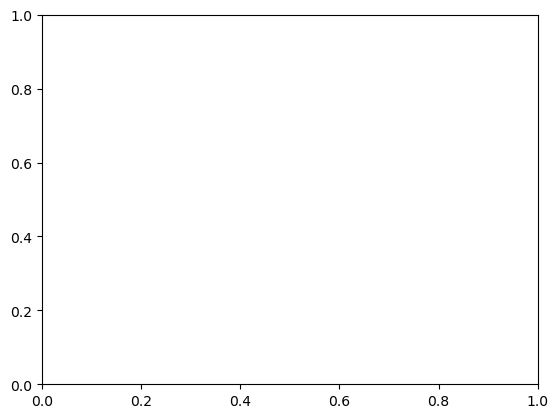

In [25]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, Icv, label='vac complex')
plt.plot(scatter.q, Ipv + Ilv + 2* Iplvc, label='vac separate')
plt.yscale('log')
plt.legend()

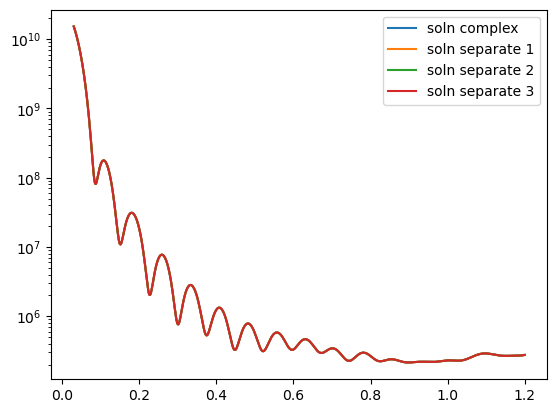

In [8]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, Ics, label='soln complex')
plt.plot(scatter.q, Icv + Iwc + 2 * Icwcc, label='soln separate 1')
plt.plot(scatter.q, Ipv + Ilv + 2 * Iplvc + Iwc + 2 * Icwcc, label='soln separate 2')
plt.plot(scatter.q, Ipv + Ilv + 2 * Iplvc + Iwc + 2 * Ipwcc + 2 * Ilwcc, label='soln separate 3')
plt.yscale('log')
plt.legend()

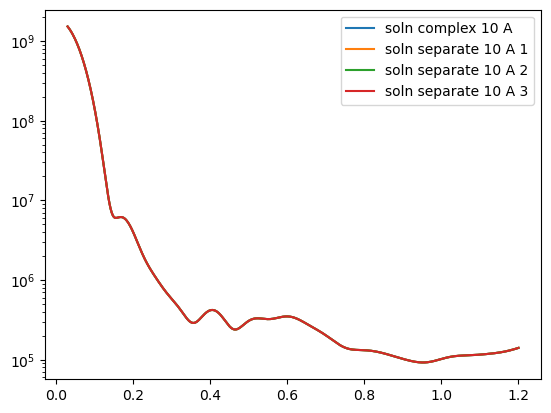

In [9]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, Ics10, label='soln complex 10 A')
plt.plot(scatter.q, Icv + Iwc10 + 2 * Icwcc10, label='soln separate 10 A 1')
plt.plot(scatter.q, Ipv + Ilv + 2 * Iplvc + Iwc10 + 2 * Icwcc10, label='soln separate 10 A 2')
plt.plot(scatter.q, Ipv + Ilv + 2 * Iplvc + Iwc10 + 2 * Ipwcc10 + 2 * Ilwcc10, label='soln separate 10 A 3')
plt.yscale('log')
plt.legend()

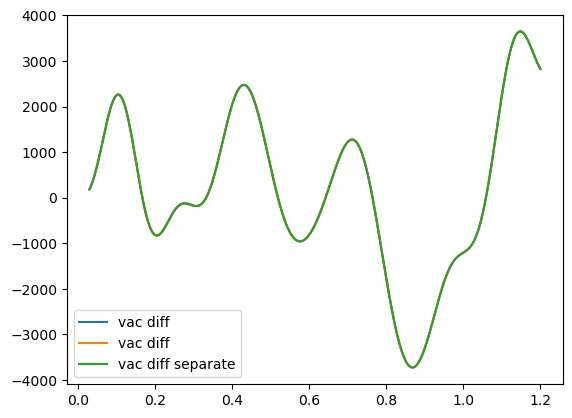

In [87]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, scatter.q**3 * dIv, label='vac diff')
plt.plot(scatter.q, scatter.q**3 * (Icv - Ipv), label='vac diff')
plt.plot(scatter.q, scatter.q**3 * (2*Iplvc + Ilv), label='vac diff separate')
plt.legend()

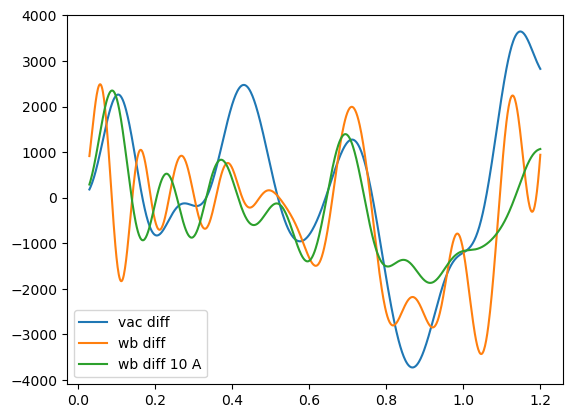

In [91]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, scatter.q**3 * dIv, label='vac diff')
plt.plot(scatter.q, scatter.q**3 * dIs, label='wb diff')
plt.plot(scatter.q, scatter.q**3 * dIs10, label='wb diff 10 A')
plt.legend()

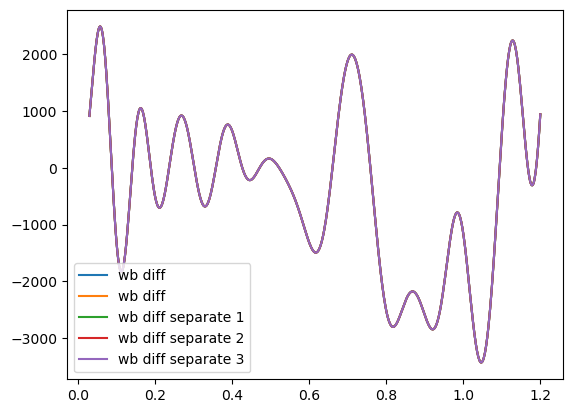

In [89]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, scatter.q**3 * dIs, label='wb diff')
plt.plot(scatter.q, scatter.q**3 * (Ics - Ips), label='wb diff')
plt.plot(scatter.q, scatter.q**3 * (Icv + Iwc + 2 * Icwcc - Ipv - Iwp - 2 * Ipwpc), label='wb diff separate 1')
plt.plot(scatter.q, scatter.q**3 * (Ilv + 2 * Iplvc + Iwc - Iwp + 2 * Ipwcc + 2 * Ilwcc - 2 * Ipwpc), label='wb diff separate 2')
plt.plot(scatter.q, scatter.q**3 * (dIv + Iwc - Iwp + 2 * Ipwcc + 2 * Ilwcc - 2 * Ipwpc), label='wb diff separate 3')
plt.legend()

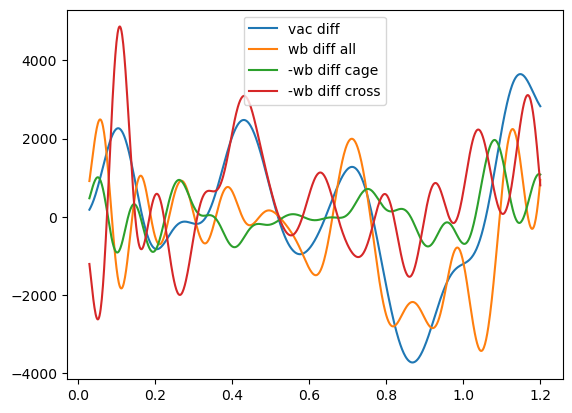

In [90]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, scatter.q**3 * dIv, label='vac diff')
plt.plot(scatter.q, scatter.q**3 * dIs, label='wb diff all')
plt.plot(scatter.q, scatter.q**3 * -(Iwc - Iwp), label='-wb diff cage')
plt.plot(scatter.q, scatter.q**3 * -(2 * Ipwcc + 2 * Ilwcc - 2 * Ipwpc), label='-wb diff cross')
plt.legend()

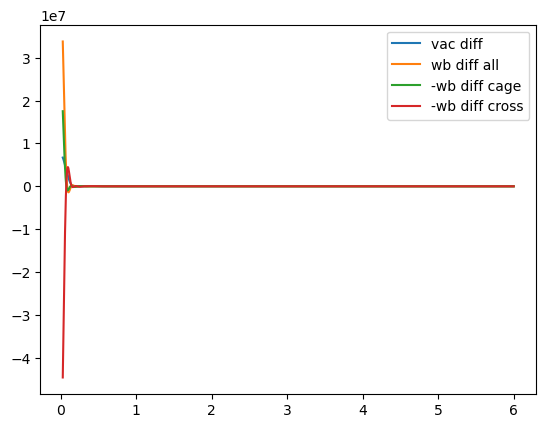

In [78]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, dIv, label='vac diff')
plt.plot(scatter.q, dIs, label='wb diff all')
plt.plot(scatter.q, -(Iwc - Iwp), label='-wb diff cage')
plt.plot(scatter.q, -(2 * Ipwcc + 2 * Ilwcc - 2 * Ipwpc), label='-wb diff cross')
plt.legend()

In [207]:
# Solve for the scaling factor for trial density

def res_func_analytical(Idata, Iprior, Icross, Iguess, sigqdata):
    a = np.sum(2 * Icross * (Idata - Iprior) / sigqdata**2) # zeroth order term
    b = np.sum(-(4 * Icross**2 - 2 * Iguess * (Idata - Iprior)) / sigqdata**2)
    c = np.sum(-6 * Iguess * Icross / sigqdata**2)
    d = np.sum(-2 * Iguess**2 / sigqdata**2)
    eq = poly.Polynomial((a, b, c, d))
    roots = eq.roots()
#     print(f'analytical roots: {roots}')
    chi = np.inf
    root_best = 0
    for root_c in roots[np.isreal(roots)]:
        root = root_c.real
        chi_this = np.sum(((Idata - Iprior - Icross * 2 * root - Iguess * root * root) / sigqdata)**2)/Idata.size
        if chi_this < chi:
            chi = chi_this
            root_best = root
#     print(f'analytical gives {chi} at {root_best}')
    return root_best
# Add to weight
# Flatten negative weight

In [208]:
def write_pdb_line(f,*j):
    j = list(j)
    j[0] = j[0].ljust(6)#atom#6s
    j[1] = j[1].rjust(5)#aomnum#5d
    j[2] = j[2].center(4)#atomname$#4s
    j[3] = j[3].ljust(3)#resname#1s
    j[4] = j[4].rjust(1) #Astring
    j[5] = j[5].rjust(4) #resnum
    j[6] = str('%8.3f' % (float(j[6]))).rjust(8) #x
    j[7] = str('%8.3f' % (float(j[7]))).rjust(8)#y
    j[8] = str('%8.3f' % (float(j[8]))).rjust(8) #z\
    j[9] =str('%6.2f'%(float(j[9]))).rjust(6)#occ
    j[10]=str('%6.2f'%(float(j[10]))).ljust(6)#temp
    j[11]=j[11].rjust(12)#elname
    f.write("%s%s %s %s %s%s    %s%s%s%s%s%s\n"% (j[0],j[1],j[2],j[3],j[4],j[5],j[6],j[7],j[8],j[9],j[10],j[11]))
            
def write_out(xyz, weight, fname, grid=None, op=None, mode='w', save_space=True):
    with open(fname, mode) as f:
        for i_ in range(len(xyz)):
            if weight[i_] > 0 or not save_space:
                i = i_ + 1
                write_pdb_line(f,'ATOM', str(i), 'X', 'X', 'A', '1', *xyz[i_], weight[i_]*100, 1.0, 'X')
        f.write('END\n')

    if grid is not None:
        if op is not None:
            allowed = op.flatten()
        else:
            allowed = np.ones_like(weight)
        with open(grid, mode) as f:
            for i_ in range(len(xyz)):
#                 if weight[i_] > 0:
                    i = i_ + 1
                    write_pdb_line(f,'ATOM', str(i), 'X', 'X', 'A', '1', *xyz[i_], allowed[i_], 1.0, 'X')
            f.write('END\n')

In [209]:
import time
from scipy import ndimage
def refine(xyz, trial_list, op, S_calc_all, S_err, scatter, apo,
           steps=10000,
           timing_step=500,
           flatten_step=100,
           connectivity_step=1000,
           weight_max=0.05,
           struct_connectivity_A=4,
           grid_spacing=0.75,
           start_refine=5000,
           do_trial=True,
           write_traj=None,
           write_fname=None,
           input_weight=None):
    
    n_origins = len(trial_list)
    if input_weight is None:
        weight = np.random.random(len(xyz))
        weight[~op.flatten()] = 0
        S_calc_pro, S_calc_trial, S_calc_cross = \
                scatter.cross_scatter(apo, prior=np.empty((0, 3)), weight_p=np.empty(0), 
                                      trial=xyz[op.flatten()], weight_t=weight[op.flatten()], timing=False)
        S_calc_pro_before = S_calc_pro.copy() # Initial curve

        chi_zero = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        chi_before = (((S_calc_all - S_calc_pro - S_calc_trial - 2 * S_calc_cross) / S_err)**2).sum() / (len(S_calc_all) - 1)
        scaling = res_func_analytical(S_calc_all, S_calc_pro, S_calc_cross, S_calc_trial, S_err)
        print(f'Initial scaling: {scaling:.3f}')
        weight[op.flatten()] *= scaling
        weight_trial = weight.copy()
        S_calc_pro, _, _ = \
                scatter.cross_scatter(apo, prior=xyz, weight_p=weight, 
                                      trial=xyz, timing=False)
        chi_after = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        print(chi_zero, chi_before, chi_after, (weight>0).sum())
    else:
        weight = input_weight
        
    chi_trace = []
    scale_trace = []
    fine_timing_trace = []


    timing_step = timing_step
    flatten_step = flatten_step
    connectivity_step = connectivity_step
    weight_max = weight_max
    struct_connectivity = int(struct_connectivity_A / spacing)
    start_refine = start_refine
    trial = do_trial
    write_traj = write_traj
    if trial:
        weight_trial = weight.copy()

    t0 = time.time()
    t01 = time.time()
    for idx in range(steps+1):

        choice = np.random.choice(np.arange(n_origins))
        if idx > start_refine:
            while (weight[trial_idx[choice]] > 0).sum() < len(trial_idx[choice]) / 2:
                # limit sampling to near existing density
                choice = np.random.choice(np.arange(n_origins))
        S_calc_pro, S_calc_trial, S_calc_cross = \
            scatter.cross_scatter(apo, prior=xyz[weight > 0], weight_p=weight[weight > 0], 
                                  trial=trial_list[choice], timing=False)
        chi_before = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        scaling = res_func_analytical(S_calc_all, S_calc_pro, S_calc_cross, S_calc_trial, S_err)



        if trial:
            # Risk of increasing chi^2, so recalc 
            weight_trial[trial_idx[choice]] += scaling
            weight_trial[weight_trial<0] = 0
            S_calc_pro, S_calc_trial, S_calc_cross = \
                scatter.cross_scatter(apo, prior=xyz[weight_trial > 0], weight_p=weight_trial[weight_trial > 0], 
                                      trial=trial_list[choice], timing=False)
            chi_after = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)

            if chi_after < chi_before:
                weight = weight_trial.copy()
                scale_trace.append(scaling)
            else:
                weight_trial = weight.copy()
                scale_trace.append(np.nan)
            chi = min(chi_after, chi_before)
        else:
            chi = chi_before
            scale_trace.append(scaling)
            weight[trial_idx[choice]] += scaling
            weight[weight<0] = 0

        chi_trace.append(chi)    

        if flatten_step is not None and idx > 0 and idx % flatten_step == 0:
            # flatten
            weight[weight < weight.max() * weight_max] = 0

        if connectivity_step is not None:
            enforce_connectivity = False
            if isinstance(connectivity_step, list):
                enforce_connectivity = idx in connectivity_step
            elif (idx > 0 and idx % connectivity_step == 0):
                enforce_connectivity = True
            # Pick largest feature
            if enforce_connectivity:
                struct = ndimage.generate_binary_structure(3, struct_connectivity)
                labeled_support, num_features = ndimage.label(weight.reshape(op.shape), structure=struct)
                labeled_support = labeled_support.flatten()
                sums = np.zeros((num_features))

                #find the feature with the greatest number of electrons
                for feature in range(num_features+1):
                    sums[feature-1] = np.sum(weight[labeled_support==feature])
                big_feature = np.argmax(sums)+1

                #remove features from the support that are not the primary feature
                weight[labeled_support != big_feature] = 0
                print()
                print(f'Stray feature removal: Map has {num_features} blobs, removing {num_features-1} of them')
                print(f'Zeroed {sums.sum() - np.max(sums):.2f} carbon-equivalents, {np.max(sums):.2f} remaining')

        if write_traj is not None and idx > 0 and idx % write_traj == 0:
            if idx == write_traj:
                write_out(xyz, weight, 'traj.pdb', mode='w', save_space=False)
            else:
                write_out(xyz, weight, 'traj.pdb', mode='a', save_space=False)


        if timing_step is not None and idx > 0 and idx % timing_step == 0:
            t1 = time.time()
            if idx == timing_step:
                t2 = t0
            print(f'Timing step {idx}: {(t1 - t0):.2f}s ({(t1-t0)/idx*1000:.2f} ms/step | {idx/(t1-t0):.2f} steps/s | ', end='')
            print(f'this {timing_step} steps: {timing_step/(t1-t2):.2f} steps/s)')
            t2 = time.time()

        print(f'Step {idx:4d}: scaling = {scaling:.4e}, chi^2 = {chi:.4e}', end='\r')
        t00 = time.time()
        fine_timing_trace.append(t00 - t01)
        t01 = time.time()
    final_S_calc, _ , _ = \
            scatter.cross_scatter(apo, prior=xyz[weight_trial > 0], weight_p=weight_trial[weight_trial > 0], 
                                  trial=trial_list[choice], timing=False)
    return weight, chi_trace, scale_trace, fine_timing_trace, final_S_calc

In [232]:
weight_list = []
chi_list = []
for idx in range(10):
    print(f'\n\n### Run {idx} ###')
    weight, chi_trace, scale_trace, fine_timing_trace, final_S_calc = \
        refine(xyz, trial_list, allowed_points, S_calc_all, S_err, scatter, apo_mol, grid_spacing=spacing,
               steps=10000, connectivity_step=1000, timing_step=500, weight_max=0.1,
               struct_connectivity_A=3)#, input_weight=weight.copy())
    weight_list.append(weight)
    chi_list.append(chi_trace[-1])



### Run 0 ###
Initial scaling: 0.023
1.1817753621893832 861840.3909178969 0.3305607023537954 4903
Timing step 500: 17.74s (35.47 ms/step | 28.19 steps/s | this 500 steps: 28.19 steps/s)
Step  999: scaling = -1.9046e-03, chi^2 = 2.8453e-02
Stray feature removal: Map has 18 blobs, removing 17 of them
Zeroed 0.81 carbon-equivalents, 45.70 remaining
Timing step 1000: 35.45s (35.45 ms/step | 28.21 steps/s | this 500 steps: 28.23 steps/s)
Timing step 1500: 53.30s (35.53 ms/step | 28.14 steps/s | this 500 steps: 28.01 steps/s)
Step 1999: scaling = -2.5781e-04, chi^2 = 2.5846e-02
Stray feature removal: Map has 30 blobs, removing 29 of them
Zeroed 1.63 carbon-equivalents, 42.15 remaining
Timing step 2000: 71.06s (35.53 ms/step | 28.14 steps/s | this 500 steps: 28.15 steps/s)
Timing step 2500: 88.82s (35.53 ms/step | 28.15 steps/s | this 500 steps: 28.15 steps/s)
Step 2999: scaling = 4.8757e-04, chi^2 = 2.5988e-022
Stray feature removal: Map has 40 blobs, removing 39 of them
Zeroed 2.05 carbon

Timing step 3500: 124.52s (35.58 ms/step | 28.11 steps/s | this 500 steps: 28.29 steps/s)
Step 3999: scaling = -2.6778e-03, chi^2 = 2.7880e-02
Stray feature removal: Map has 30 blobs, removing 29 of them
Zeroed 1.27 carbon-equivalents, 37.03 remaining
Timing step 4000: 141.96s (35.49 ms/step | 28.18 steps/s | this 500 steps: 28.68 steps/s)
Timing step 4500: 159.39s (35.42 ms/step | 28.23 steps/s | this 500 steps: 28.68 steps/s)
Step 4999: scaling = -2.2288e-03, chi^2 = 2.6419e-02
Stray feature removal: Map has 41 blobs, removing 40 of them
Zeroed 2.27 carbon-equivalents, 38.21 remaining
Timing step 5000: 176.60s (35.32 ms/step | 28.31 steps/s | this 500 steps: 29.05 steps/s)
Timing step 5500: 194.19s (35.31 ms/step | 28.32 steps/s | this 500 steps: 28.43 steps/s)
Step 5999: scaling = -5.1942e-04, chi^2 = 2.5246e-02
Stray feature removal: Map has 27 blobs, removing 26 of them
Zeroed 0.94 carbon-equivalents, 36.54 remaining
Timing step 6000: 211.64s (35.27 ms/step | 28.35 steps/s | this 

Timing step 9500: 331.37s (34.88 ms/step | 28.67 steps/s | this 500 steps: 28.75 steps/s)
Step 9999: scaling = 3.9501e-04, chi^2 = 2.2984e-022
Stray feature removal: Map has 9 blobs, removing 8 of them
Zeroed 15.21 carbon-equivalents, 20.76 remaining
Timing step 10000: 348.71s (34.87 ms/step | 28.68 steps/s | this 500 steps: 28.83 steps/s)
Step 10000: scaling = -9.5669e-04, chi^2 = 2.2980e-02

### Run 7 ###
Initial scaling: 0.022
1.1817753621893832 955170.1482186391 0.33414389617428436 4903


In [221]:
weight_list = np.array(weight_list)

In [222]:
weight_list.mean(0).shape

(5508,)

In [223]:
for idx, w in enumerate(weight_list):
    write_out(xyz, w, f'data/2CM7/run{idx}.pdb')

In [224]:
write_out(xyz, weight_list.mean(0), 'data/2CM7/run_average.pdb', grid='data/2CM7/grid.pdb', op=allowed_points)

In [225]:
(1/np.array(chi_list)[:, None] * weight_list).sum(0) / (1/np.array(chi_list)).sum()

array([0., 0., 0., ..., 0., 0., 0.])

In [226]:
(1/np.array(chi_list)[:, None] * weight_list).sum(0).max()

75.37869673230753

In [227]:
1/np.array(chi_list)

array([39.22850709, 36.61297311, 43.10010482, 36.84120177, 41.1767749 ,
       33.30226128, 46.68359547, 36.93448556, 42.01172661, 42.59744262])

In [228]:
weighted_weight = (1/np.array(chi_list)[:, None] * weight_list).sum(0) / (1/np.array(chi_list)).sum()
write_out(xyz, weighted_weight, 'data/2CM7/run_average_weighted.pdb', grid='data/2CM7/grid.pdb', op=allowed_points)

Text(0, 0.5, 'Timing (ms)')

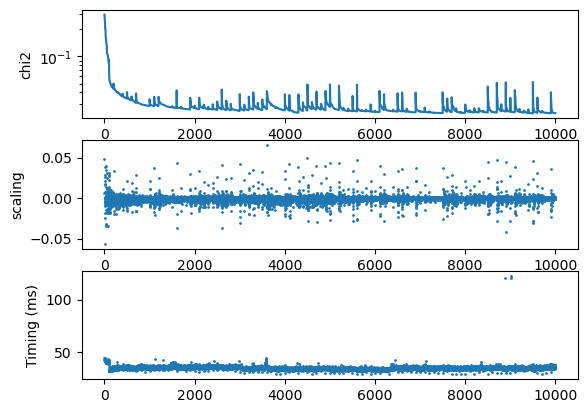

In [229]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1)
ax[0].plot(chi_trace)
ax[0].set_yscale('log')
ax[0].set_ylabel('chi2')
ax[1].plot(scale_trace,'.', markersize=2)
ax[1].set_ylabel('scaling')
ax[2].plot(np.array(fine_timing_trace)*1000,'.', markersize=2)
ax[2].set_ylabel('Timing (ms)')


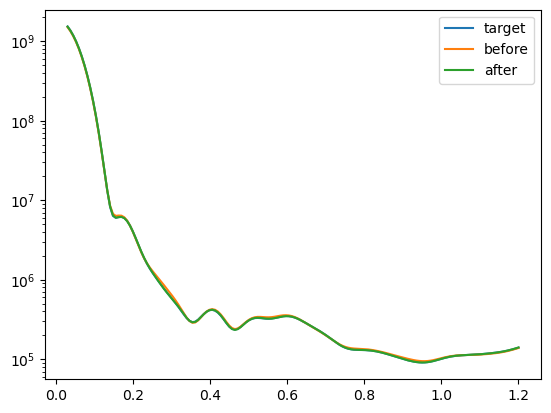

In [230]:

plt.plot(scatter.q, S_calc_all, label='target')
plt.yscale('log')
plt.plot(scatter.q, S_calc_pro_before, label='before')
plt.plot(scatter.q, final_S_calc, label='after')
# plt.plot(scatter.q, S_calc_trial, label='chain B')
# plt.plot(scatter.q, S_calc_cross, label='chain A x chain B')
# plt.plot(scatter.q, S_calc_pro + S_calc_trial + 2 * S_calc_cross, label='trial')
plt.legend()

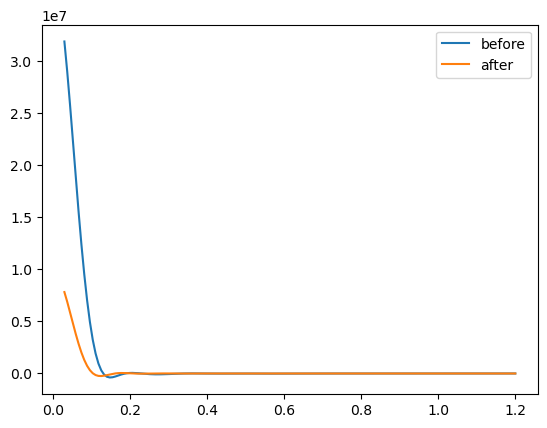

In [231]:
# plt.plot(scatter.q, S_calc_all, label='target')
# plt.yscale('log')
plt.plot(scatter.q, S_calc_all -S_calc_pro_before, label='before')
plt.plot(scatter.q, S_calc_all - final_S_calc, label='after')
# plt.plot(scatter.q, S_calc_trial, label='chain B')
# plt.plot(scatter.q, S_calc_cross, label='chain A x chain B')
# plt.plot(scatter.q, S_calc_pro + S_calc_trial + 2 * S_calc_cross, label='separate')
plt.legend()

In [180]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, (S_calc_all - S_calc_pro) / S_calc_all)

NameError: name 'S_calc_pro' is not defined